In [1]:
"""
This will define a neural net
"""
from keras import backend as K 
K.clear_session()
from keras import regularizers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
from extra_keras_utils import is_gpu_available
from keras.utils import plot_model
import numpy as np
import crocoddyl
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle


Using TensorFlow backend.
/home/alienware/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alienware/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alienware/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alienware/.local/lib/python3.6/site-packages/tenso

In [2]:
def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def max_error(y_true, y_pred):
    """
    Best score = 0
    """
    return K.max(K.abs(y_true - y_pred))


def kerasNet(x_data,
             y_data,
             NUNITS_INPUT = 64,
             NUNITS = 32,
             NHIDDEN = 2,
             lr = 1e-3,
             EPOCHS = 100,
             BATCHSIZE = 32,
             validation_split = 0.3,
             VERBOSE = 2,
             optimizer:str = "sgd",
             loss = ['mean_squared_error'],
             use_gpu:bool = True,
             saveModel: bool = False,
             plot_results:bool = True,
             baseline:bool = False                     
            ):
    """
    2 hidden layers, sigmoid tanh
    
    """
    if use_gpu:
        try:
            if is_gpu_available():
                print("Using gpu!")
            
        except: print("No GPU")  
            
    model = Sequential()
    model.add(Dense(NUNITS_INPUT, input_dim=(x_data.shape[1]), activation = "relu", name="First"))
    for _ in range(NHIDDEN):
        if baseline:
            model.name = "Baseline"
            model.add(Dense(NUNITS,
                      activation = "tanh"                           
                    ))           
        else:
            model.name = "Network1"
            model.add(Dense(NUNITS,
                        activation = "tanh",
                        kernel_initializer = 'random_uniform',
                        bias_initializer = 'random_normal',
                        kernel_regularizer=regularizers.l2(0.01),
                        activity_regularizer=regularizers.l1(0.01)    
                        )) 
            

    model.add(Dense(y_data.shape[1],                    
                   activation = 'linear',
                   name = "Final"))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics = [rmse, max_error, 'mae']
                  )
        

    
    print("X_Train : ", x_data.shape," and Y_Train: ", y_data.shape)
    history = model.fit(x_data, 
                        y_data,
                        validation_split = validation_split,
                        epochs = EPOCHS,
                        batch_size= BATCHSIZE,
                        verbose = VERBOSE
                        ).history
    
    print(model.summary())
    plot_history(history)


    
    if saveModel:
        model.save(name + '.h5')
        print("Saved Model")
    return model

In [3]:


def griddedData(n_points:int = 1500,
                xy_limits:list = [-1.9,1.9],
                theta_limits:list = [-np.pi/2, np.pi/2]
                ):
    size = int(np.sqrt(n_points)) + 1
    min_x, max_x = [*xy_limits]
    xrange = np.linspace(min_x,max_x,size, endpoint=True)
    trange = np.linspace(*theta_limits, size, endpoint=True)
    points = np.array([ [x1,x2, x3] for x1 in xrange for x2 in xrange for x3 in trange])
    np.random.shuffle(points)
    points = points[0:n_points, : ]
    return points

In [4]:
states = griddedData(10000, xy_limits=[-1.9,1.9],theta_limits=[-np.pi/2, np.pi/2])
x = []
y = []
for x0 in tqdm(states):
    model = crocoddyl.ActionModelUnicycle()
    model.costweights = np.array([1., 1.]).T
    problem = crocoddyl.ShootingProblem(x0.T, [model]*30, model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve([], [] , 1000)
    
    xs = np.array(ddp.xs[1:]).flatten()
    x.append(x0)
    y.append(xs)
    
x = np.array(x)
y = np.array(y)

100%|██████████| 10000/10000 [00:12<00:00, 797.07it/s]


X_Train :  (10000, 3)  and Y_Train:  (10000, 90)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
 - 1s - loss: 0.0899 - rmse: 0.1482 - max_error: 1.8279 - mae: 0.0503 - val_loss: 0.0382 - val_rmse: 0.1528 - val_max_error: 1.8767 - val_mae: 0.0510
Epoch 2/100
 - 0s - loss: 0.0329 - rmse: 0.1481 - max_error: 1.8318 - mae: 0.0497 - val_loss: 0.0332 - val_rmse: 0.1529 - val_max_error: 1.8749 - val_mae: 0.0510
Epoch 3/100
 - 0s - loss: 0.0292 - rmse: 0.1481 - max_error: 1.8297 - mae: 0.0497 - val_loss: 0.0301 - val_rmse: 0.1529 - val_max_error: 1.8748 - val_mae: 0.0510
Epoch 4/100
 - 0s - loss: 0.0280 - rmse: 0.1481 - max_error: 1.8258 - mae: 0.0497 - val_loss: 0.0296 - val_rmse: 0.1529 - val_max_error: 1.8743 - val_mae: 0.0511
Epoch 5/100
 - 0s - loss: 0.0279 - rmse: 0.1481 - max_error: 1.8227 - mae: 0.0498 - val_loss: 0.0296 - val_rmse: 0.1528 - val_max_error: 1.8751 - val_mae: 0.0511
Epoch 6/100
 - 0s - loss: 0.0279 - rmse: 0.1481 - max_error: 1.8230 - mae: 0.0497 - val_loss

Epoch 50/100
 - 0s - loss: 0.0276 - rmse: 0.1481 - max_error: 1.8268 - mae: 0.0498 - val_loss: 0.0295 - val_rmse: 0.1528 - val_max_error: 1.8778 - val_mae: 0.0511
Epoch 51/100
 - 0s - loss: 0.0282 - rmse: 0.1481 - max_error: 1.8249 - mae: 0.0498 - val_loss: 0.0291 - val_rmse: 0.1528 - val_max_error: 1.8760 - val_mae: 0.0511
Epoch 52/100
 - 0s - loss: 0.0278 - rmse: 0.1481 - max_error: 1.8208 - mae: 0.0498 - val_loss: 0.0292 - val_rmse: 0.1528 - val_max_error: 1.8756 - val_mae: 0.0511
Epoch 53/100
 - 0s - loss: 0.0278 - rmse: 0.1481 - max_error: 1.8311 - mae: 0.0498 - val_loss: 0.0293 - val_rmse: 0.1529 - val_max_error: 1.8753 - val_mae: 0.0511
Epoch 54/100
 - 0s - loss: 0.0278 - rmse: 0.1481 - max_error: 1.8327 - mae: 0.0498 - val_loss: 0.0287 - val_rmse: 0.1528 - val_max_error: 1.8759 - val_mae: 0.0511
Epoch 55/100
 - 0s - loss: 0.0275 - rmse: 0.1481 - max_error: 1.8350 - mae: 0.0498 - val_loss: 0.0290 - val_rmse: 0.1529 - val_max_error: 1.8756 - val_mae: 0.0511
Epoch 56/100
 - 0s - l

Model: "Network1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
Final (Dense)                (None, 90)                5850      
Total params: 14,426
Trainable params: 14,426
Non-trainable params: 0
_________________________________________________________________
None


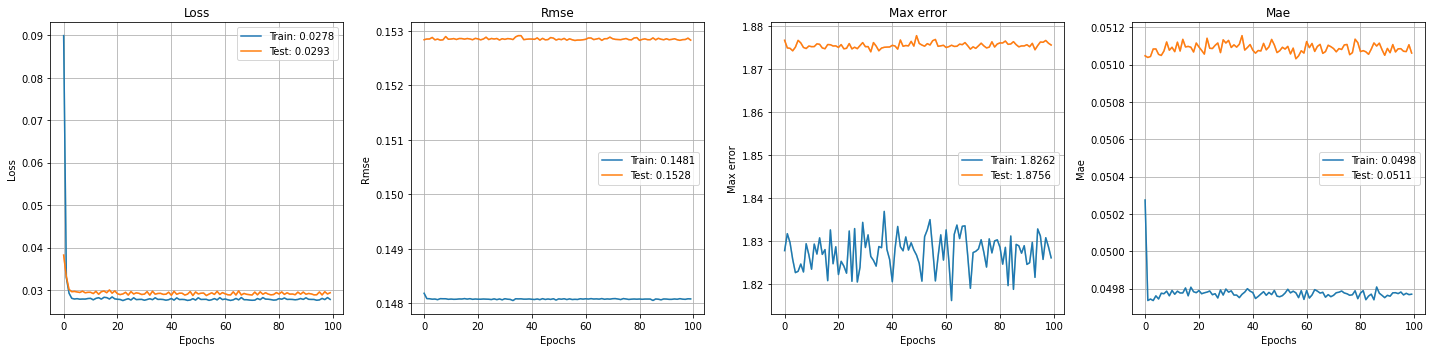

In [5]:
x, y = shuffle(x, y, random_state=0)

net = kerasNet(x,
             y,
             NUNITS_INPUT = 64,
             NUNITS = 64,
             NHIDDEN = 2,
             lr = 1e-2,
             EPOCHS = 100,
             BATCHSIZE = 16,
             validation_split = 0.1,
             VERBOSE = 2,
             optimizer = "adam",
             loss = ['mean_squared_error'],
             saveModel = False,
             plot_results = True,
             baseline = False    )

Warmstarted  13
ColdStarted 13


/home/alienware/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


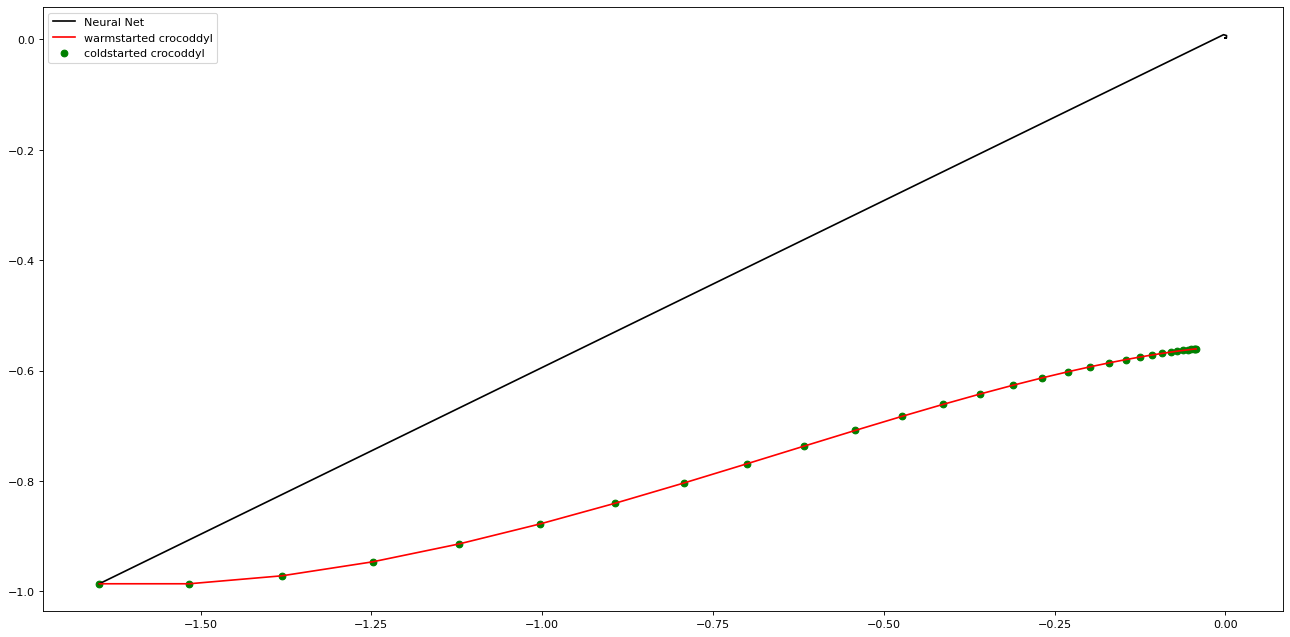

In [6]:
import random
def point(h:float= 0., k:float = 0., r:int = 2):
    """
    Generate random points from the circumference of a circle
    (h, k) -> center
    r  = radius
    """
    theta = random.random() * 2 * np.pi
    return h + np.cos(theta) * r, k + np.sin(theta) * r

#x, y = point()
#initial_state = [-1.5, -2., 0] 
initial_state = [random.uniform(-2, 2), random.uniform(-2, 2), 0.0]


model = crocoddyl.ActionModelUnicycle()

x_test = np.array(initial_state).reshape(1, -1)
y_pred = net.predict(x_test)
warm = y_pred.reshape(30, 3)
init_xs = []
init_xs.append(np.array(initial_state))
for i in warm:
    a = np.array(i)
    init_xs.append(a)

    
# Warmstarting    
model.costWeights = np.matrix([1, 1]).T
problem = crocoddyl.ShootingProblem(np.matrix(initial_state).T, [ model ] * 30, model)
ddp = crocoddyl.SolverDDP(problem)
ddp.solve(init_xs, [], 1000)
ddp_xs = np.array(ddp.xs)
print("Warmstarted " , ddp.iter)

#ColdStart
del model, ddp, problem
model2 = crocoddyl.ActionModelUnicycle()
model2.costWeights = np.matrix([1, 1]).T
problem2 = crocoddyl.ShootingProblem(np.matrix(initial_state).T, [ model2 ] * 30, model2)
ddp2 = crocoddyl.SolverDDP(problem2)
ddp2.solve([], [], 1000)
ddp2_xs = np.array(ddp2.xs)
print("ColdStarted" ,ddp2.iter)


import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 80
plt.figure(figsize=(20, 10))
plt.axis(aspect='image')
#plt.xlim(-2.1, 2.1)
#plt.ylim(-2.1, 2.1)
init_xs = np.array(init_xs)
plt.plot(init_xs[:,0], init_xs[:,1], c = 'black', label="Neural Net")
plt.plot(ddp_xs[:,0], ddp_xs[:,1], c = 'red', label = 'warmstarted crocoddyl')
plt.scatter(ddp2_xs[:,0], ddp2_xs[:,1], c = 'green', label = 'coldstarted crocoddyl')
plt.legend()
